In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import tensorflow as tf
from   tensorflow import keras

from fornado.toymodel_example  import toy_model, generate_training_data
from fornado.fornado_model     import setup_model
from fornado.fornado_inference import predict_fortran


In [2]:
if False : # example with multiple output dimensions
    n_input  = 4
    n_output = 2
    n_hidden = 5
    n_npl = 20
    n_training = 30000
    act='csu'
    
else : # example with one output dimension (--> see additional test below)
    n_input  = 7
    n_output = 1
    n_hidden = 30
    n_npl = 20
    n_training = 30000
    act='csu'

tdata = generate_training_data( n_input, n_output, n_training, seed=1 )
vdata = generate_training_data( n_input, n_output, 1000, seed=2 )
sdata = generate_training_data( n_input, n_output, 100, seed=3 )

tdata['x'].shape, tdata['y'].shape

((30000, 7), (30000, 1))

In [3]:
model, model_id = setup_model( n_input=tdata['x'].shape[1], n_output=tdata['y'].shape[1], n_npl=n_npl, n_hidden=n_hidden, output_activation='linear', activation=act)

registering csu activation function...
registering csu activation function...
>>> using loss function  mse


In [4]:
history = model.fit( tdata['x'], tdata['y'], validation_data = ( vdata['x'], vdata['y'] ),
                     epochs=20, verbose=1, batch_size=32 )

Epoch 1/20
938/938 [==============================] - 18s 13ms/step - loss: 1.5765 - mae: 0.9882 - val_loss: 0.2732 - val_mae: 0.4127
Epoch 2/20
938/938 [==============================] - 11s 12ms/step - loss: 0.2155 - mae: 0.3650 - val_loss: 0.1096 - val_mae: 0.2562
Epoch 3/20
938/938 [==============================] - 11s 12ms/step - loss: 0.1199 - mae: 0.2742 - val_loss: 0.1279 - val_mae: 0.2846
Epoch 4/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0953 - mae: 0.2450 - val_loss: 0.0764 - val_mae: 0.2226
Epoch 5/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0821 - mae: 0.2275 - val_loss: 0.0720 - val_mae: 0.2142
Epoch 6/20
938/938 [==============================] - 11s 11ms/step - loss: 0.0724 - mae: 0.2129 - val_loss: 0.0887 - val_mae: 0.2397
Epoch 7/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0578 - mae: 0.1898 - val_loss: 0.0367 - val_mae: 0.1513
Epoch 8/20
938/938 [==============================] - 11s 11ms

In [5]:
y = model.predict( sdata['x'] )
y.shape, y.mean(), y.ndim

((100, 1), 1.0772804, 2)

In [6]:
y_ftn = {}
modes=['scalar','scalar_withifs', 'vector', 'vector_native', 'omp', 'omp_native']
print('ERROR wrt TF')
for mode in modes :
    y_ftn[mode] = predict_fortran( model, sdata['x'], mode=mode )
    diff = y_ftn[mode] - y
    print('{:30s} : RMSE={}, BIAS={}, MAX={}'.format( mode, np.sqrt((diff**2).mean()), diff.mean(), np.abs(diff).max() ))
    
print()
print('ERROR wrt scalar')
for mode in modes :
    if mode != 'scalar' :    
        diff = y_ftn[mode] - y_ftn['scalar']
        print('{:30s} : RMSE={}, BIAS={}, MAX={}'.format( mode, np.sqrt((diff**2).mean()), diff.mean(), np.abs(diff).max() ))


ERROR wrt TF
scalar                         : RMSE=6.515774657600559e-07, BIAS=-8.66502531948754e-08, MAX=1.7881393432617188e-06
scalar_withifs                 : RMSE=6.474065799011441e-07, BIAS=-8.247792493421002e-08, MAX=1.7881393432617188e-06
vector                         : RMSE=7.135540727176704e-07, BIAS=-1.6257166635114118e-07, MAX=1.9073486328125e-06
vector_native                  : RMSE=6.479054377450666e-07, BIAS=-9.955838464748012e-08, MAX=1.7881393432617188e-06
omp                            : RMSE=7.173590006459563e-07, BIAS=-1.7389655226907053e-07, MAX=1.9073486328125e-06
omp_native                     : RMSE=6.45257728137949e-07, BIAS=-1.071579731615202e-07, MAX=1.7881393432617188e-06

ERROR wrt scalar
scalar_withifs                 : RMSE=3.816559512870299e-08, BIAS=4.172325152040912e-09, MAX=2.384185791015625e-07
vector                         : RMSE=6.198224582476541e-07, BIAS=-7.592141315626577e-08, MAX=2.0265579223632812e-06
vector_native                  : RMSE=6.7

0.114362046 1.0772804 0.9629184


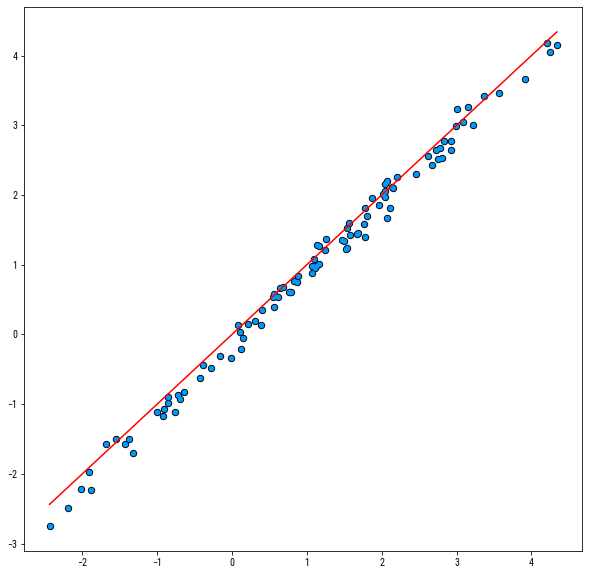

In [7]:
if y.ndim == 2 :
    print( (y-sdata['y']).mean(), y.mean(), sdata['y'].mean() )
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter( y, sdata['y'], c='k', s=40 )
    ax.scatter( y_ftn['scalar'], sdata['y'], c='#0099ff', s=20 )
    ax.plot( (y.min(),y.max()), (y.min(),y.max()), 'r')
else :
    fix, ax = plt.subplots( 1, y.ndim, figsize=(5*y.ndim,5))
    for d in range(y.ndim) :
        ax[d].scatter( y[:,d], sdata['y'][:,d], c='k', s=40 )
        ax[d].scatter( y_ftn['scalar'][:,d], sdata['y'][:,d], c='g', s=20 )
        ax[d].plot( (y[:,d].min(),y[:,d].max()), (y[:,d].min(),y[:,d].max()), 'r')
        

COMPARISON OF TANGENT LINEAR CODE WITH FINITE DIFFERENCES

1.9459403e-06
tangent     -0.0017153356 0.0006798709 -0.00035153652
nonlinear   -0.0017161369 0.00067925453 -0.00035164788


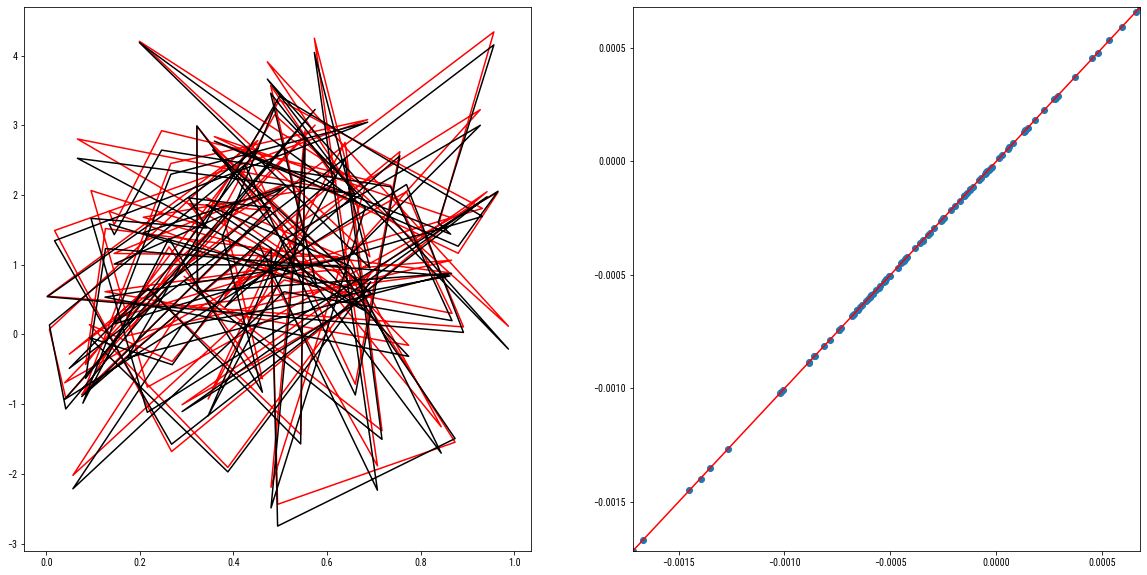

In [8]:
x0 = sdata['x']
xd = x0[::-1,:]*0.0001
y0, yd = predict_fortran( model, x0, xd=xd, mode='tangent' )
x0d = x0 + xd
#y0d = predict_fortran( model, x0d, mode='vector' )
y0d, _ = predict_fortran( model, x0d, xd=xd, mode='tangent' )
yd_nl = y0d - y

_, xb = predict_fortran( model, x0, yb=yd, mode='adjoint' )

fig, ax = plt.subplots( 1, 2, figsize=(20,10))
ax[0].plot( x0[:,0], y0, 'r' )
ax[0].plot( x0[:,0], sdata['y'], 'k' )
ax[1].scatter( yd, yd_nl)
ax[1].plot( (yd.min(),yd.max()), (yd.min(),yd.max()), 'r' )
ax[1].set_xlim((yd.min(),yd.max()))
ax[1].set_ylim((yd.min(),yd.max()))
print( abs( yd - yd_nl ).max() )
print( 'tangent    ', yd.min(), yd.max(), yd.mean() )
print( 'nonlinear  ', yd_nl.min(), yd_nl.max(), yd_nl.mean() )

In [9]:
x0[0,:], xd[0,:], y0[0,:], yd[0,:], xb[0,:]

(array([0.5507979 , 0.7081478 , 0.29090473, 0.5108276 , 0.89294696,
        0.8962931 , 0.12558532], dtype=float32),
 array([2.9493853e-05, 5.6128913e-05, 3.2594155e-05, 6.5796107e-06,
        6.9026821e-05, 3.0863768e-05, 3.9228518e-05], dtype=float32),
 array([2.0674915], dtype=float32),
 array([8.083264e-05], dtype=float32),
 array([-4.5267047e-05, -1.3992743e-04, -1.7376360e-04, -3.2081740e-04,
         3.7748547e-04,  3.6784381e-04, -3.5464388e-04], dtype=float32))

SCALAR PRODUCT TEST FOR ADJOINT

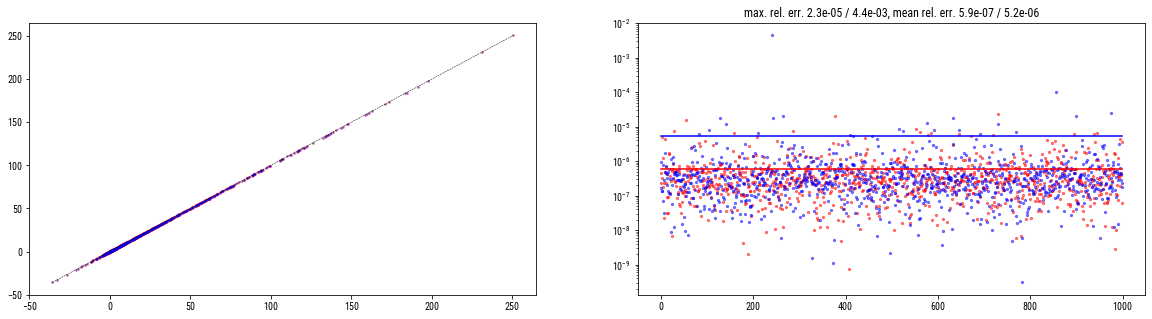

In [10]:
np.random.seed(17)
n_samples = 1000
a = np.random.random(( n_samples, n_input ))
b = np.random.random(( n_samples, n_input ))
c = np.random.random(( n_samples, n_input )) # = x0
    
y0, La = predict_fortran( model, c, xd=a, mode='tangent' )
y0, Lb = predict_fortran( model, c, xd=b, mode='tangent' )
    
y0, LtLa = predict_fortran( model, c, yb=La, mode='adjoint' )
y0, LtLb = predict_fortran( model, c, yb=Lb, mode='adjoint' )

p1v = np.zeros(n_samples)
p2v = np.zeros(n_samples)
p3v = np.zeros(n_samples)
for s in range(n_samples) :
    p1, p2, p3 = np.dot(La[s,...],Lb[s,...]), np.dot(LtLa[s,...],b[s,...]), np.dot(a[s,...],LtLb[s,...])
    #print( s, p1, p2, p3, abs((p2-p1)/p1), abs((p3-p1)/p1) )
    p1v[s] = p1; p2v[s] = p2; p3v[s] = p3
    
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter( p1v, p2v, c='r', s=5, alpha=0.2 )
ax[0].scatter( p1v, p3v, c='b', s=1, alpha=0.4 )
ax[0].plot( (p1v.min(),p1v.max()), (p1v.min(),p1v.max()), '--k', linewidth=0.5)
ax[1].scatter( np.arange(n_samples), abs((p2v-p1v)/p1v), c='r', s=5, alpha=0.5 )
ax[1].scatter( np.arange(n_samples), abs((p3v-p1v)/p1v), c='b', s=5, alpha=0.5 )
ax[1].set_yscale('log')
#ax[1].set_ylim((0,5e-6))
ax[1].set_title('max. rel. err. {:.1e} / {:.1e}, mean rel. err. {:.1e} / {:.1e}'.format(
                abs((p2v-p1v)/p1v).max(),  abs((p3v-p1v)/p1v).max(),
                abs((p2v-p1v)/p1v).mean(), abs((p3v-p1v)/p1v).mean() ));
ax[1].plot( (0,n_samples-1), [abs((p2v-p1v)/p1v).mean()]*2, 'r' )
ax[1].plot( (0,n_samples-1), [abs((p3v-p1v)/p1v).mean()]*2, 'b' )


For n_output = 1, AD can be replaced by calling TL n_input times:

In [11]:
if n_output == 1 :
    np.random.seed(13)
    n_samples = 5
    a = np.random.random(( n_samples, n_input ))
    a[:,1:] = 0.0 # keep only dimension 0
    b = np.random.random(( n_samples, n_input ))
    b[:,2:] = 0.0 # keep only dimension 1
    b[:,0] = 0.0
    c = np.random.random(( n_samples, n_input )) # = x0

    y0, La = predict_fortran( model, c, xd=a, mode='tangent' )
    y0, Lb = predict_fortran( model, c, xd=b, mode='tangent' )

    print('La shape', La.shape, '  a shape', a.shape)
    print('a[0,:]', a[0,:])

    dydx0 = La[:,0]/a[:,0]
    dydx1 = Lb[:,0]/b[:,1]


    y0, LtLa = predict_fortran( model, c, yb=La, mode='adjoint' )
    y0, LtLb = predict_fortran( model, c, yb=Lb, mode='adjoint' )

    print('LtLa shape', LtLa.shape, '  La shape', La.shape)

    dydx0d = LtLa[:,0]/La[:,0]
    dydx1d = LtLa[:,1]/La[:,0]

    print()
    print( 'Derivatives computed using TL code several times')
    print( ' dydx0 = ', dydx0 )
    print( ' dydx1 = ', dydx1 )
    print()
    print( 'Derivatives computed using AD code once')
    print( ' dydx0d = ', dydx0d )
    print( ' dydx1d = ', dydx1d )
else :
    print('implement me for n_output > 1. It would require n_input * n_output TL calls to replace AD.')



La shape (5, 1)   a shape (5, 7)
a[0,:] [0.77770241 0.         0.         0.         0.         0.
 0.        ]
LtLa shape (5, 7)   La shape (5, 1)

Derivatives computed using TL code several times
 dydx0 =  [-0.72647528 -0.42153619 -0.34061628 -0.69977135 -0.66799625]
 dydx1 =  [-0.59671948 -2.00205399 -0.59947548 -0.46559149 -1.87321592]

Derivatives computed using AD code once
 dydx0d =  [-0.7264752  -0.42153588 -0.3406165  -0.69977146 -0.66799664]
 dydx1d =  [-0.5967201 -2.0020528 -0.5994757 -0.4655912 -1.8732156]


BENCHMARKS

In [12]:
benchmark=True
if benchmark :
    import cProfile
    bdata = generate_training_data( n_input, n_output, 1000000, seed=1 )

In [13]:
if benchmark :
    cProfile.run("y_scalar = predict_fortran( model, bdata['x'], mode='scalar', nchunk=2048 )")

         7968 function calls (7902 primitive calls) in 12.445 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.445   12.445 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _asarray.py:236(asfortranarray)
        1    0.000    0.000    0.000    0.000 _methods.py:37(_amax)
      286    0.000    0.000    0.000    0.000 abc.py:96(__instancecheck__)
       62    0.000    0.000    0.001    0.000 array_ops.py:244(identity)
        1    0.000    0.000    0.005    0.005 backend.py:3630(batch_get_value)
        1    0.000    0.000    0.005    0.005 backend.py:3646(<listcomp>)
      130    0.000    0.000    0.000    0.000 base_layer.py:1280(trainable)
       65    0.000    0.000    0.001    0.000 base_layer.py:1345(trainable_weights)
       65    0.000    0.000    0.000    0.000 base_layer.py:1363(non_trainable_weights)
       65    0.000    0.000    0.001    0.000 base_layer.py:1387(

In [14]:
if benchmark :
    cProfile.run("y, yd = predict_fortran( model, bdata['x'], xd=bdata['x'], mode='tangent', nchunk=2048 )")

         7972 function calls (7906 primitive calls) in 16.723 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   16.723   16.723 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _asarray.py:236(asfortranarray)
        1    0.000    0.000    0.000    0.000 _methods.py:37(_amax)
      286    0.000    0.000    0.000    0.000 abc.py:96(__instancecheck__)
       62    0.000    0.000    0.002    0.000 array_ops.py:244(identity)
        1    0.000    0.000    0.006    0.006 backend.py:3630(batch_get_value)
        1    0.000    0.000    0.006    0.006 backend.py:3646(<listcomp>)
      130    0.000    0.000    0.000    0.000 base_layer.py:1280(trainable)
       65    0.000    0.000    0.001    0.000 base_layer.py:1345(trainable_weights)
       65    0.000    0.000    0.000    0.000 base_layer.py:1363(non_trainable_weights)
       65    0.000    0.000    0.001    0.000 base_layer.py:1387(

In [15]:
if benchmark :
    cProfile.run("y, xb = predict_fortran( model, bdata['x'], yb=y, mode='adjoint', nchunk=2048 )")

         7973 function calls (7907 primitive calls) in 15.462 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   15.462   15.462 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _asarray.py:236(asfortranarray)
        1    0.000    0.000    0.000    0.000 _methods.py:37(_amax)
      286    0.000    0.000    0.000    0.000 abc.py:96(__instancecheck__)
       62    0.000    0.000    0.001    0.000 array_ops.py:244(identity)
        1    0.000    0.000    0.005    0.005 backend.py:3630(batch_get_value)
        1    0.000    0.000    0.005    0.005 backend.py:3646(<listcomp>)
      130    0.000    0.000    0.000    0.000 base_layer.py:1280(trainable)
       65    0.000    0.000    0.001    0.000 base_layer.py:1345(trainable_weights)
       65    0.000    0.000    0.000    0.000 base_layer.py:1363(non_trainable_weights)
       65    0.000    0.000    0.001    0.000 base_layer.py:1387(